In [1]:
# 需要用到的函数
import numpy as np


def softmax(x):
    if x.ndim==2:
        x=x.T
        x=x-np.max(x,axis=0)    # 防止溢出的对策
        y=np.exp(x)/np.sum(np.exp(x),axis=0)
        return y.T
    
    x=x-np.max(x)    # 防止溢出的对策
    y=np.exp(x)/np.sum(np.exp(x))
    return y


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t  = t.argmax(axis=1)    # 最大值所在的索引
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [2]:
# 每个层的类
class Affine:
    def __init__(self,w,b):
        self.W=w
        self.b=b
        self.x=None
        self.dW=None
        self.db=None
        
    def forward(self,x):
        self.x=x
        out=self.x.dot(self.W)+self.b
        return out
    
    def backward(self,dout):
        dx=dout.dot(self.W.T)
        self.dW=self.x.T.dot(dout)
        self.db=np.sum(dout,axis=0)
        return dx
    
    
class Sigmoid:
    def __init__(self,x):
        self.out=None
        
    def forward(self,x):
        out=1/(1+np.exp(-x))
        self.out=out
        return out
    
    def backward(self,dout):
        dout=dout*self.out(1-self.out)
        return dout
    

class ReLU:
    def __init__(self):
        self.out=None
        
    def forward(self,x):
        mask=(x<=0)
        self.mask=mask
        out=x.copy()
        out[mask]=0
        return out
    
    def backward(self,dout):
        dout[self.mask]=0
        return dout
    
    
class SoftMaxWithLoss:
    def __init__(self):
        self.loss=None
        self.y=None
        self.t=None
        
    def forward(self,x,t):
        """注意这里返回的是误差"""
        self.t=t
        self.y=softmax(x)
        self.loss=cross_entropy_error(self.y,self.t)
        return self.loss
    
    def backward(self,dout=1):
        batchsize=self.t.shape[0]    # 批大小
        dx=(self.y-self.t)/batchsize
        return dx    # 似乎与dout无关

In [3]:
from collections import OrderedDict


class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        # 初始化权重
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size)
        self.params['b1']=np.zeros(hidden_size)
        self.params['W2']=weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b2']=np.zeros(output_size)
        
        # 各个层
        self.layers=OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['ReLU']=ReLU()
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.lastLayer=SoftMaxWithLoss()
        
    def predict(self,x):
        """前向传播"""
        for layer in self.layers.values():
            x=layer.forward(x)
        return x
    
    def loss(self,x,t):
        y=self.predict(x)
        return self.lastLayer.forward(y,t)    # 这里.forward的参数x应该是前面几层的输出y
    
    def accuracy(self,x,t):
        y=self.predict(x)
        y=np.argmax(y,axis=1)    # 获取最大值索引,看来这里也是批
        if t.ndim!=1:    # 批处理时，可能会导致t维度为2，因为1个样本对应会输出一个列向量y
            t=np.argmax(t,axis=1)
        accuracy=np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    def gradient(self,x,t):
        self.loss(x,t)    # 不可略，因为其中涉及到前向传播
        
        dout=1
        dout=self.lastLayer.backward(dout)
        layers=list(self.layers.values())
        layers.reverse()
        
        # 反向传播
        for layer in layers:
            dout=layer.backward(dout)
            
        grads={}
        grads['W1']=self.layers['Affine1'].dW
        grads['b1']=self.layers['Affine1'].db
        grads['W2']=self.layers['Affine2'].dW
        grads['b2']=self.layers['Affine2'].db
        
        return grads         

In [4]:
# 神经网络的训练
from dataset.mnist import load_mnist

# 读入数据
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,one_hot_label=True)

network=TwoLayerNet(input_size=784,hidden_size=50,output_size=10,)

## 训练的一些超参数
iters_num=10000
train_size=x_train.shape[0]
batch_size=100
learning_rate=0.1

train_loss=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch=max(iters_num/batch_size,1)    # 每iter_per_epoch次迭代后打印一下

## 训练，采用mini-batch方法训练
for iter in range(iters_num):
    batch_mask=np.random.choice(train_size,batch_size)
    x_batch=x_train[batch_mask]
    t_batch=t_train[batch_mask]
    
    # 计算梯度
    grads=network.gradient(x_batch,t_batch)
    
    # 梯度下降法更新权重
    for key in ['W1','b1','W2','b2']:
        network.params[key]-=learning_rate*grads[key]
        
    # 损失计算
    loss=network.loss(x_batch,t_batch)
    train_loss.append(loss)
    
    if iter%iter_per_epoch==0:
        train_acc=network.accuracy(x_train,t_train)    # 注意是在整体测试集上的精度,
        test_acc=network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        

Text(0, 0.5, 'loss in train')

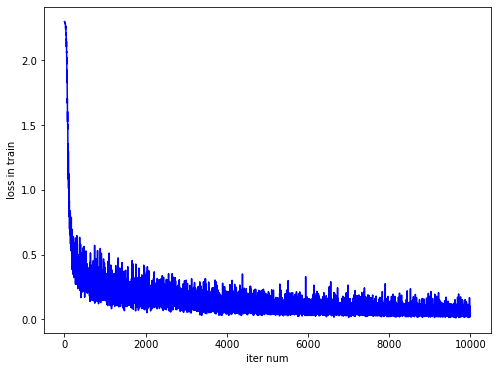

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
plt.plot(np.array(train_loss),'b-')
plt.xlabel('iter num')
plt.ylabel('loss in train')


Text(0, 0.5, 'acc in train')

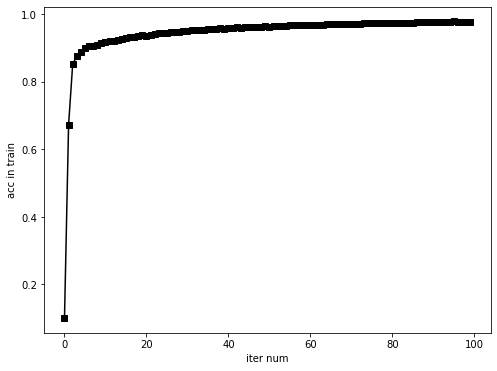

In [6]:
plt.figure(figsize=(8,6))
plt.plot(np.array(train_acc_list),'k-s')
plt.xlabel('iter num')
plt.ylabel('acc in train')


Text(0, 0.5, 'loss in test')

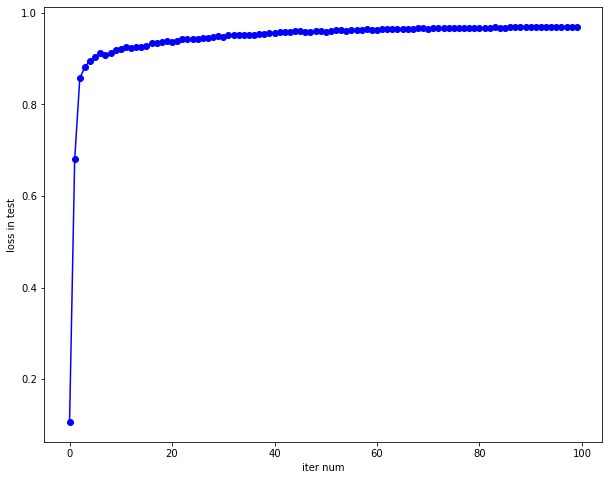

In [7]:
plt.figure(figsize=(10,8))
plt.plot(np.array(test_acc_list),'b-o')
plt.xlabel('iter num')
plt.ylabel('loss in test')


In [8]:
# 最终在测试集上的精度
network.accuracy(x_test, t_test)


0.9703

### 上面的网络只有两层，下面试一下三层的神经网络：

In [9]:
from collections import OrderedDict


class ThreeLayerNet:
    def __init__(self,input_size,
                 hidden_size1,hidden_size2,
                 output_size,
                 weight_init_std=0.01):
        # 初始化权重
        self.params={}
        self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=weight_init_std*np.random.randn(hidden_size1,hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=weight_init_std*np.random.randn(hidden_size2,output_size)
        self.params['b3']=np.zeros(output_size)
        
        self.layers=OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['ReLU1']=ReLU()
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['ReLU2']=ReLU()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        # 最后一层
        self.lastLayer=SoftMaxWithLoss()
    
    def predict(self,x):
        for layer in self.layers.values():
            x=layer.forward(x)
        return x
    
    def loss(self,x,t):
        y=self.predict(x)
        return self.lastLayer.forward(y,t)
    
    def accuracy(self,x,t):
        y=self.predict(x)
        y=np.argmax(y,axis=1)
        t=np.argmax(t,axis=1)
        
        return np.sum(y==t)/x.shape[0]
    
    def gradient(self,x,t):
        self.loss(x,t)    # 前向传播
        
        dout=1  # 最后一层的反向输入，为1
        dout=self.lastLayer.backward(dout)
        
        layers=list(self.layers.values())  # 将所有的层按顺序放入列表中
        layers.reverse()  # 反向传播，需要从最后一层开始，一直向前传播
        
        for layer in layers:    # 反向传播
            dout=layer.backward(dout)
            
        # 获取梯度
        grads={}
        grads['W1']=self.layers['Affine1'].dW
        grads['b1']=self.layers['Affine1'].db
        grads['W2']=self.layers['Affine2'].dW
        grads['b2']=self.layers['Affine2'].db
        grads['W3']=self.layers['Affine3'].dW
        grads['b3']=self.layers['Affine3'].db
        
        return grads
    
    

In [10]:
# 训练
network3=ThreeLayerNet(input_size=784,hidden_size1=50,hidden_size2=50,output_size=10,)

iters_num=5000
train_loss=[]
train_acc_list=[]
test_acc_list=[]

for iter in range(iters_num):
    # 随机获取小批量数据
    batch_mask=np.random.choice(train_size,batch_size)
    x_batch=x_train[batch_mask]
    t_batch=t_train[batch_mask]
    
    grads=network3.gradient(x_batch,t_batch)    # 计算梯度
    
    # 梯度下降法更新权重
    for key in ['W1','b1','W2','b2','W3','b3']:
        network3.params[key]-=learning_rate*grads[key]
    
    # 损失计算
    loss=network3.loss(x_batch,t_batch)
    train_loss.append(loss)
    
    # 每个一定的iter，计算精度
    if iters_num%iter_per_epoch==0:
        train_acc=network3.accuracy(x_train,t_train)
        test_acc=network3.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

In [11]:
len(train_loss)

5000

Text(0, 0.5, 'loss in train')

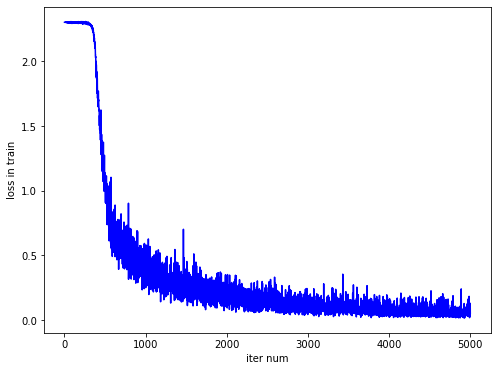

In [12]:
plt.figure(figsize=(8,6))
plt.plot(np.array(train_loss),'b-')
plt.xlabel('iter num')
plt.ylabel('loss in train')

Text(0, 0.5, 'loss in train')

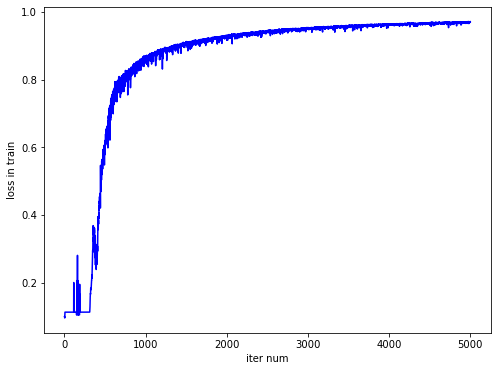

In [13]:
plt.figure(figsize=(8,6))
plt.plot(np.array(train_acc_list),'b-')
plt.xlabel('iter num')
plt.ylabel('loss in train')

Text(0, 0.5, 'loss in test')

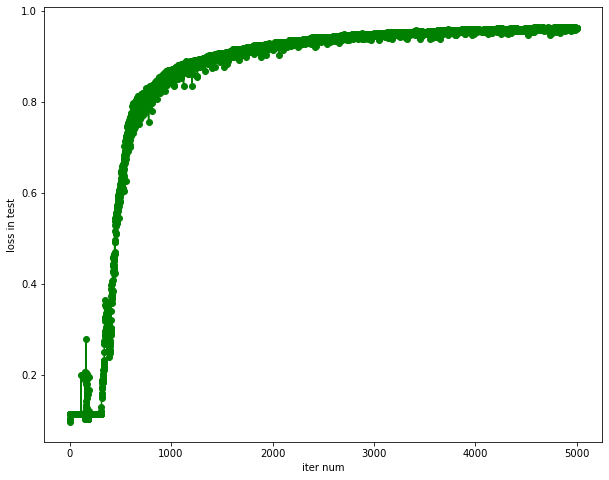

In [14]:
plt.figure(figsize=(10,8))
plt.plot(np.array(test_acc_list),'g-o')
plt.xlabel('iter num')
plt.ylabel('loss in test')


In [15]:
# 最终在测试集上的精度
network3.accuracy(x_test, t_test)


0.9632